# Dataset Preparation

# Imports

In [1]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.transforms import Resize, InterpolationMode
import torchaudio
from torchaudio.transforms import MelSpectrogram, FrequencyMasking
import librosa
import cv2
from pathlib import Path
from os import listdir, scandir

# Importaciones adicionales para EfficientNet
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchsummary import summary
from torchmetrics import Accuracy, Precision, Recall, F1Score

# Helper functions

In [2]:
def plot_spectogram(specgram, title=None, ylabel='freq_bin'):
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin='lower', aspect='auto')

# Start preparing dataset

In [3]:
workdir_path = Path('../data')
sample_rate = 48000

data = []
with scandir(workdir_path) as entries:
    for entry in entries:
        if entry.is_dir():
            path_to_dir = workdir_path / entry.name

            for filename in listdir(path_to_dir):
                path_to_audio = path_to_dir / filename

                data.append((path_to_audio, int(filename[0])))

audio_df = pd.DataFrame(data, columns=['path_to_audio', 'class'])

audio_df

,path_to_audio,class
0,..\data\01\0_01_0.wav,0
1,..\data\01\0_01_1.wav,0
2,..\data\01\0_01_10.wav,0
3,..\data\01\0_01_11.wav,0
4,..\data\01\0_01_12.wav,0
...,...,...
29995,..\data\60\9_60_5.wav,9
29996,..\data\60\9_60_6.wav,9
29997,..\data\60\9_60_7.wav,9
29998,..\data\60\9_60_8.wav,9


In [4]:
n_classes = audio_df['class'].max() + 1
print(f'There are {n_classes} classes in the dataset')

There are 10 classes in the dataset


# Create dataset

In [5]:
# Aumentamos la resolución para EfficientNet
n_channels = 3  # EfficientNet requiere 3 canales
n_mels = 224    # Tamaño estándar para EfficientNet
time = 224      # Tamaño estándar para EfficientNet

transform = torch.nn.Sequential(
    MelSpectrogram(sample_rate, n_fft=1024, n_mels=64),
    Resize(size=(n_mels, time), interpolation=InterpolationMode.BICUBIC)
)

In [6]:
class AudioDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_sample_path = self.df.iloc[idx, 0]
        class_id = self.df.iloc[idx, 1]
        
        # Cargar archivo de audio
        waveform, sample_rate = torchaudio.load(audio_sample_path)
        
        # Aplicar transformación (convertir a espectrograma)
        if self.transform:
            spectrogram = self.transform(waveform)
            
            # Convertir a 3 canales para EfficientNet
            # Repetimos el canal para crear una imagen RGB
            spectrogram = spectrogram.repeat(3, 1, 1)
            
            # Normalizar valores entre 0 y 1
            if spectrogram.max() > 0:
                spectrogram = spectrogram / spectrogram.max()
        
        return spectrogram, class_id

In [7]:
# Crear dataset
audio_dataset = AudioDataset(df=audio_df, transform=transform)

# Verificar una muestra
sample, label = audio_dataset[0]
print(audio_df.iloc[0, 0])
print(f'sample.shape: {sample.shape}, sample.class: {label}')

..\data\01\0_01_0.wav
sample.shape: torch.Size([3, 224, 224]), sample.class: 0


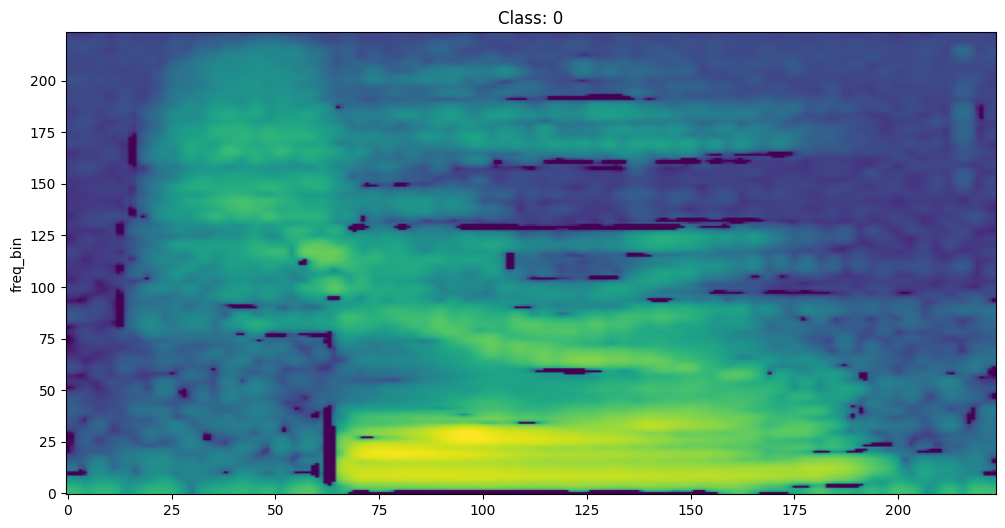

In [8]:
# Visualizar espectrograma
plot_spectogram(sample[0], title=f'Class: {label}')

In [9]:
# Dividir dataset en train, validation y test
train_size = int(0.8 * len(audio_dataset))
val_size = int(0.1 * len(audio_dataset))
test_size = len(audio_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    audio_dataset, [train_size, val_size, test_size]
)

print(f'Train size: {len(train_dataset)}')
print(f'Validation size: {len(val_dataset)}')
print(f'Test size: {len(test_dataset)}')

Train size: 24000
Validation size: 3000
Test size: 3000


In [10]:
# Crear dataloaders
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# EfficientNet Model

In [11]:
class AudioEfficientNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Cargar modelo pre-entrenado EfficientNet-B0
        self.efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        
        # Modificar la última capa para nuestro número de clases
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = nn.Linear(in_features, n_classes)
    
    def forward(self, x):
        return self.efficientnet(x)

In [12]:
# Verificar si hay GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 3060


In [13]:
# Crear modelo
model = AudioEfficientNet(n_classes=n_classes)
model = model.to(device)

# Mostrar resumen del modelo
summary(model, (3, n_mels, time))

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\PC MASTER USER/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 25.2MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [16]:
# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

In [17]:
# Definir métricas
accuracy = Accuracy(task='multiclass', num_classes=n_classes).to(device)
precision = Precision(task='multiclass', num_classes=n_classes, average='macro').to(device)
recall = Recall(task='multiclass', num_classes=n_classes, average='macro').to(device)
f1 = F1Score(task='multiclass', num_classes=n_classes, average='macro').to(device)

ValueError: Optional arg `num_classes` must be type `int` when task is ClassificationTask.MULTICLASS. Got <class 'numpy.int64'>

In [ ]:
# Función para entrenar el modelo
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_acc += accuracy(outputs, labels) * inputs.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

In [ ]:
# Función para evaluar el modelo
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_acc += accuracy(outputs, labels) * inputs.size(0)
            running_precision += precision(outputs, labels) * inputs.size(0)
            running_recall += recall(outputs, labels) * inputs.size(0)
            running_f1 += f1(outputs, labels) * inputs.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    epoch_precision = running_precision / len(dataloader.dataset)
    epoch_recall = running_recall / len(dataloader.dataset)
    epoch_f1 = running_f1 / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1

In [ ]:
# Entrenar el modelo
num_epochs = 10
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

In [ ]:
# Función para graficar el historial de entrenamiento
def plot_history(history, net_name='EfficientNet'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='train')
    ax1.plot(history['val_loss'], label='val')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{net_name} Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='train')
    ax2.plot(history['val_acc'], label='val')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{net_name} Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history['val_precision'], label='precision')
    plt.plot(history['val_recall'], label='recall')
    plt.plot(history['val_f1'], label='f1')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title(f'{net_name} Validation Metrics')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Graficar historial de entrenamiento
plot_history(history, net_name='EfficientNet')

In [ ]:
# Evaluar en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

In [ ]:
# Guardar el modelo
torch.save(model.state_dict(), 'efficientnet_audio_model.pth')
print('Modelo guardado correctamente')